# Web Scraping for Reddit & Predicting Comments



## Problem Statement

Determine which characteristics of a post on Reddit contribute most to the overall interaction as measured by number of comments.


## Preamble

In this project, we practiced some essential skills:

- Collecting data by scraping a website using the Python package `requests` and using the Python library `BeautifulSoup` which efficiently extracts HTML code. We scraped the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/) and acquired the following pieces of information about each thread:

   - The title of the thread
   - subreddit that the thread corresponds to
   - The length of time it has been up on Reddit
   - The number of comments on the thread

- Using Natural Language Processing (NLP) techniques to preprocess the data. NLP, in a nutshell, is "how to transform text data and convert it to features that enable us to build models." These techniques include:

    - Tokenization (splitting text into pieces based on given patterns)
    - Removing stopwords
    - Stemming (returns the base form of the word)
    - Lemmatization (return the word's *lemma*)

- After the step above we obtain *numerical* features which allow for algebraic computations. We then build a `RandomForestClassifier` and use it to classify each post according to the corresponding number of comments associated with it. More concretely the model predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

## 1) Importing

We first need to  `import`  the necessary packages

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # see the value of multiple statements at once.
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer
import requests
from bs4 import BeautifulSoup
import json
import datetime
import csv
import time
import pandas as pd
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## 2) Scraping

The sub-items below are:

2.1) Describe scraping strategy

2.2) I write four functions to extract the items above, namely, thread title, its subreddit, the time it has been up and the number of comments

2.3) I then write a function that finds the last `id` on the page, and stores it.

2.4) I use the functions above to parse out the 4 fields - title, time, subreddit, and number of comments.

2.5) I then create a `Dataframe` from the results with those 4 columns.

2.6) I save the results into  `csv` file

### 2.1) General Strategy

The general strategy is:

- Use the `requests` Python packages to make a `.get` request (the object `res` is a `Response` object):   

        res = requests.get(URL,headers={"user-agent":'mt'})
     
- Create a BeautifulSoup object from the HTML

        soup = BeautifulSoup(res.content,"lxml")

- We then use `.extract` to see the page structure:

        soup.extract

The page has the following structure:

- The thread title is within an `<a>` tag with the attribute `data-event-action="title"`.
- The time since the thread was created is within a `<time>` tag with attribute `class="live-timestamp"`.
- The subreddit is within an `<a>` tag with the attribute `class="subreddit hover may-blank"`.
- The number of comments is within an `<a>` tag with the attribute data-event-action="comments"`.

### 2.2) We first write four functions to extract the items above, namely, thread title, its subreddit, the time it has been up and the number of comments

In [ ]:
def extract_title_from_result(result,num=25):
    titles = []
    title = result.find_all('a', {'data-event-action':'title'})
    for i in title:
        titles.append(i.text)
    return titles

def extract_time_from_result(result,num=25):
    times = []
    time = result.find_all('time', {'class':'live-timestamp'})
    for i in time:
        times.append(i.text)
    return times

def extract_subreddit_from_result(result,num=25):
    subreddits = []
    subreddit = result.find_all('a', {'class':'subreddit hover may-blank'})
    for i in subreddit:
        subreddits.append(i.string)
    return subreddits

def extract_num_from_result(result,num=25):
    nums_lst = []
    nums = result.find_all('a', {'data-event-action': 'comments'})
    for i in nums:
        nums_lst.append(i.string)
    return nums_lst

### 2.3) We then write a function that finds the last `id` on the page, and stores it.

In [ ]:
def get_urls(n=25):
    j=0   # counting loops
    titles = []
    times = []
    subreddits = []
    nums = []
    URLS = []
    URL = "http://www.reddit.com"

    for _ in range(n):

        res = requests.get(URL, headers={"user-agent":'mt'})
        soup = BeautifulSoup(res.content,"lxml")

        titles.extend(extract_title_from_result(soup))
        times.extend(extract_time_from_result(soup))
        subreddits.extend(extract_subreddit_from_result(soup))
        nums.extend(extract_num_from_result(soup))

        URL = soup.find('span',{'class':'next-button'}).find('a')['href']
        URLS.append(URL)
        j+=1
        print(j)
        time.sleep(3)

    return titles, times, subreddits, nums, URLS

### 2.4) I now use the functions above to parse out the 4 fields - title, time, subreddit, and number of comments.

In [ ]:
titles, times, subreddits, nums, URLS = get_urls(50)

print(len(titles))
print(len(times))
print(len(subreddits))
print(len(nums))
print(len(URLS))

### 2.5) I then create a `Dataframe` from the results with those 4 columns.

In [ ]:
df = pd.DataFrame(columns = ['titles', 'times', 'subreddits', 'nums'])
df.titles = titles
df.times = times
df.subreddits = subreddits
df.nums = nums
df.head()

### 2.6) Saving results as a `.csv` file

In [ ]:
df.to_csv('reddit_df_1.csv')

## 3) Data cleaning, preprocessing and exploratory data analysis (EDA)

### The steps are:

-Loading in the data of scraped results

- Writing a function to perform some necessary EDA steps. Among other things this function drops duplicates (a substantial part of the data is duplicated)

- Removing the `hours ago` strings in the column `times` and converting the result to integers. We do this by splitting `df['times']` to obtain lists where the first element of the list is the number of hours, which is what we are after. We then pick the first element and convert to an integer.

- We then remove the string `comments` from the column `num` using the same code as the previous cell. We use`value_counts` first, to check for errors or entries with a peculiar shape. We find that there are four entries equal to "comment" merely. We drop them.

- We remove `r/` from `subreddits.`

- We export the new `DataFrame` into a `csv` after the EDA

In [ ]:
df = pd.read_csv('reddit_df_1.csv',index_col=0)
df.head(40)

,titles,times,subreddits,nums
0,"I've lost a lot of weight, a lot of sadness, a...",1 hour ago,r/pics,1449 comments
1,Dick Winters and his Easy Company (HBO's Band ...,3 hours ago,r/ColorizedHistory,174 comments
2,JJ slowly looking more like George Lucas,5 hours ago,r/StarWars,246 comments
3,Pink Floyd’s album “The Dark Side of The Moon”...,6 hours ago,r/Music,638 comments
4,She's officially the little girl's best babysi...,3 hours ago,r/HumansBeingBros,91 comments
5,Obviously not a virus,6 hours ago,r/gaming,199 comments
6,CaT BrUtAllY StRaNgLEs DoGGo,6 hours ago,r/PeopleFuckingDying,105 comments
7,[IMAGE] These stairs count the calories that y...,7 hours ago,r/GetMotivated,600 comments
8,Obese lady knows more about cancer than Cancer...,2 hours ago,r/insanepeoplefacebook,202 comments
9,This fucking ad,7 hours ago,r/assholedesign,245 comments


In [ ]:
def eda(df,cols):
    print("How many missing values there are:")
    print("")
    print(df.isnull().sum())
    print("")
    print("Which are the data types:")
    print("")
    print(df.dtypes)
    print("")
    print("Shape with duplicates:",df.shape)
    print ("How many duplicates of {}:".format(cols),df[cols].duplicated().sum())
    df.drop_duplicates(subset=cols, keep='last', inplace=True) # drop duplicates
    print ("Now how many duplicates of {}:".format(cols),df[cols].duplicated().sum())
    print ("Shape without duplicates:",df.shape)
    for col in df:
        print (col,":",df[col].nunique())  #checking for unique entries

eda(df,['titles','subreddits'])

How many missing values there are:

titles        0
times         0
subreddits    0
nums          0
dtype: int64

Which are the data types:

titles        object
times         object
subreddits    object
nums          object
dtype: object

Shape with duplicates: (1250, 4)
How many duplicates of ['titles', 'subreddits']: 734
Now how many duplicates of ['titles', 'subreddits']: 0
Shape without duplicates: (516, 4)
titles : 514
times : 26
subreddits : 299
nums : 293


In [ ]:
df['times'] = [int(x[0]) for x in df['times'].str.split(' ')]   # Dropping 'hours ago' string
print("How many 'comment' entries there are:", df[df['nums'] == 'comment']['nums'].value_counts())
df = df[df['nums'] != 'comment']                                # Dropping entries equal to 'comment' from nums column
df['nums'] = [int(x[0]) for x in df['nums'].str.split(' ')]     # Dropping 'comments' from nums column
df['subreddits'] = df['subreddits'].str[2:]                     # Dropping the 'r/' from subreddits

How many 'comment' entries there are: comment    4
Name: nums, dtype: int64


In [ ]:
df.head(20)

,titles,times,subreddits,nums
178,rainy afternoon,11,raining,10
180,Well this tweet took a wild turn,19,trashy,1242
181,Sweet ki..........nvm!,3,yesyesyesyesno,5
187,Two drunk gentlemen try to pass each other,17,StoppedWorking,102
192,Minute of silence,4,gwent,45
196,Dandrews practices his arithmetic,7,melbourne,63
272,Downtown Vancouver [OC][4898 x 3265],6,CityPorn,5
292,My mom took this photo in Yosemite at the vall...,17,EarthPorn,34
294,So this happened today,16,FortNiteBR,89
295,Maximum Height Impulse Test,12,FortNiteBR,70


In [ ]:
df.to_csv('reddit_df_eda_1.csv')   # exporting the DataFrame after the EDA

## 4) Creating a new binary variable

We want to predict a binary variable - whether the number of comments was low or high. For that we:
- Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median).
- We convert this into a _binary_ classification problem, by predicting two classes, high vs low number of comments.

In [ ]:
df = pd.read_csv('reddit_df_eda_1.csv',index_col=0)
print("The median is:",np.median(df['nums']))
df['binary'] = df['nums'].apply(lambda x: 1 if x >= np.median(df['nums']) else 0)
df.shape
df.head()

The median is: 84.5


(512, 5)

,titles,times,subreddits,nums,binary
178,rainy afternoon,11,raining,10,0
180,Well this tweet took a wild turn,19,trashy,1242,1
181,Sweet ki..........nvm!,3,yesyesyesyesno,5,0
187,Two drunk gentlemen try to pass each other,17,StoppedWorking,102,1
192,Minute of silence,4,gwent,45,0


In [ ]:
df.to_csv('df_with_binary_1.csv')

### Calculating the baseline accuracy for this model?


The baseline accuracy is the accuracy we would get if we always predict that the number of comments is larger than the median:

$$ \text{baseline} = \frac{n_{\text{above median}}}{n_{\text{total}}}$$

Since we are using the median as a criterion for classification, the baseline should be 0.5:

In [ ]:
df = pd.read_csv('df_with_binary_1.csv')
baseline = np.mean(df['binary'])
print("The baseline accuracy is",baseline)

The baseline accuracy is 0.5


## 5) Model building I

We now create a `RandomForestClassifier` model to classify into high or low the number of comments. As a warm-up, we start by only using the `subreddits` as a feature. We first need to create dummy variables for the subreddits, which are in text format, to build our predictors (and drop one of the dummy columns):

In [ ]:
df_subred = pd.concat([df['binary'],pd.get_dummies(df['subreddits'], drop_first = True)], axis = 1)
df_subred.shape
df_subred.head()

(512, 297)

,binary,4PanelCringe,ACPocketCamp,AFL,ATBGE,AbandonedPorn,AccidentalWesAnderson,Android,AnimalsBeingBros,AnimalsBeingDerps,...,videos,wallstreetbets,warriors,westworld,wholesomememes,woof_irl,worldnews,yesyesyesyesno,youtubehaiku,zelda
178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
187,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_subred.to_csv('subred_1.csv')

### A simple case:

In the rest of the notebook I will perform a grid search to find optimal hyperparameters. Before that, however, for simplicity and purposes of illustration, I will consider a simple example with some already chosen parameters.

I will now train a Random Forest Classifier using the following function `rfTTscore` (the name stands for "random forest train/test score"). It does the following:
- Separates the data into predictors and target
- Splits the data into training and testing sets
- Instantiates a `RandomForestClassifier` and train it (i.e. fit it) on the training data
- Now, applying the model, which was fitted *using the training data*, to the remaining data i.e. the testing data, we evaluate the accuracy of the model using the mean accuracy score `.score`:

$$ {\text{mean accuracy score}} = \frac{{{\text{number of correct predictions}}}}{{{\text{number of observations}}}}$$
- We print out the class predictions
- We then print out the predicting probabilities
- The following lines build a confusion matrix
- Finally, the main features are printed out with the corresponding bar plot

The mean accuracy score is: 0.51

Is the prediction smaller (S) or larger (L) than the median:

['S', 'L', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'L', 'L', 'L', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'S', 'L', 'S', 'L', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'L', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S']

What were the probabilities of the each result above:

Probabilities that the number of comments is smaller than the media for each 

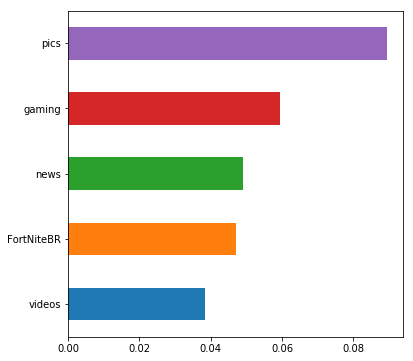

In [ ]:
def rfTTscore(df,target_col,test_size,n_estimators,max_depth):

    X = df.drop(target_col, axis=1)   # define predictors
    y = df[target_col]                # defines target

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y, test_size = test_size, random_state=42) # train/test split

    rf = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators)    #instantiates model
    rf.fit(X_train,y_train)      # fit the model to the training data

    # .score returns the mean accuracy on the test data

    print("The mean accuracy score is:",round(rf.score(X_test,y_test),2))
    print("")
    print("Is the prediction smaller (S) or larger (L) than the median:\n")
    preds = rf.predict(X_test)
    print(['S' if p == 0 else 'L' for p in rf.predict(X_test)])
    print("")
    print("What were the probabilities of the each result above:\n")
    print("Probabilities that the number of comments is smaller than the media for each observation are:\n")
    print([('S',round(p[0],2)) if p[0] > p[1] else ('S',round(p[0],2)) for p in rf.predict_proba(X_test)])
    print("")
    print("Confusion Matrix:\n")
    print(pd.crosstab(pd.concat([X_test,y_test],axis=1)['binary'], preds, rownames=['Actual Values'], colnames=['Predicted Values']))
    print('Features and their importance:\n')
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values().tail(5)
    print(feature_importances.plot(kind="barh", figsize=(6,6)))
    return

rfTTscore(df_subred,'binary',0.3,25,20)

### Comments:

- Using the subreddits only as predictors, the mean accuracy score is mediocre, slighly above the baseline value.
- The probabilities used for classifying the preditions are close to $50\%$.
- The main features are`pics`, and `gaming`

## 6) Model building II

I will now proceed with `GridSearchCV` on the training data (following lesson 4.07). The `GridSearchCV` looks for optimal hyperparameters. The function below does the following:
- Separates the data into predictors and target
- Splits the data into training and testing sets
- Defines a set of hyperparameters `rf_params` which are related to the random forest classification model (see scikitLearn documentation for more details)
- Instantiates `GridSearchCV`. The latter does the following (this is taken from `scikitLearn` docs):
  - Searches over specified parameter values of ranges for an estimator, in this case a `RandomForestClassifier`.
  - Implements a `fit` and a `score` method.
  - The parameters of the estimator are optimized by cross-validated grid-search over a parameter grid.
- The `RandomForestClassifier` is fitted to the training data
- The best parameters obtained by fitting `GridSearchCV` on the training are printed
- A `RandomForestClassifier` with optimized hyperparameters is instantiated and trained on the training data
- The mean accuracy score is evaluated in the testing data
- We print out the class predictions
- We then print out the predicting probabilities
- The following lines build a confusion matrix
- Finally, the main features are printed out with the corresponding bar plot

In [ ]:
# Defining ranges for the hyperparameters to be scanned by the grid search
n_estimators = list(range(20,220,10))
max_depth = list(range(2, 22, 2)) + [None]

def rfscore2(df,target_col,test_size,n_estimators,max_depth):

    X = df.drop(target_col, axis=1)   # predictors
    y = df[target_col]                # target

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y, test_size = test_size, random_state=42) # TT split
    rf_params = {
             'n_estimators':n_estimators,
             'max_depth':max_depth}   # parameters for grid search
    rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, verbose=1, n_jobs=-1)
    rf_gs.fit(X_train,y_train) # training the random forest with all possible parameters
    print('GridSearch results')
    print('The best parameters on the training data are:\n',rf_gs.best_params_) # printing the best parameters
    max_depth_best = rf_gs.best_params_['max_depth']      # getting the best max_depth
    n_estimators_best = rf_gs.best_params_['n_estimators']  # getting the best n_estimators
    print("best max_depth:",max_depth_best)
    print("best n_estimators:",n_estimators_best)
    best_rf_gs = RandomForestClassifier(max_depth=max_depth_best,n_estimators=n_estimators_best) # instantiate the best model
    best_rf_gs.fit(X_train,y_train)  # fitting the best model
    best_rf_score = best_rf_gs.score(X_test,y_test)
    print ("best score is:",round(best_rf_score,2))
    print("Is the prediction smaller (S) or larger (L) than the median:\n")
    preds = best_rf_gs.predict(X_test)
    print(['S' if p == 0 else 'L' for p in best_rf_gs.predict(X_test)])
    print("")
    print("What were the probabilities of the each result above:\n")
    print("Probabilities that the number of comments is smaller than the media for each observation are:\n")
    print([('S',round(p[0],2)) if p[0] > p[1] else ('S',round(p[0],2)) for p in best_rf_gs.predict_proba(X_test)])
    print("")
    print("Confusion Matrix:\n")
    print(pd.crosstab(pd.concat([X_test,y_test],axis=1)['binary'], preds, rownames=['Actual Values'], colnames=['Predicted Values']))
    print('Features and their importance:\n')
    feature_importances = pd.Series(best_rf_gs.feature_importances_, index=X.columns).sort_values().tail(5)
    print(feature_importances.plot(kind="barh", figsize=(6,6)))
    return

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:   49.7s finished


GridSearch results
The best parameters on the training data are:
 {'max_depth': 8, 'n_estimators': 100}
best max_depth: 8
best n_estimators: 100
best score is: 0.53
Is the prediction smaller (S) or larger (L) than the median:

['S', 'L', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'S', 'L', 'S', 'L', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'L', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'L', 'S', 'L', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'L', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S']

W

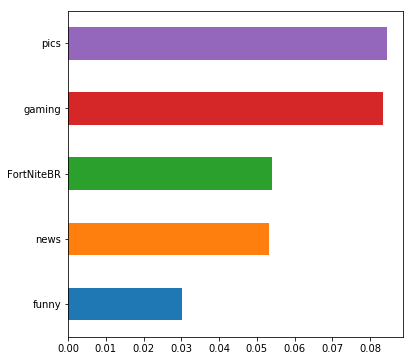

In [ ]:
rfscore2(df_subred,'binary',0.3,n_estimators,max_depth)

### Comments:

- Again, using the subreddits only as predictors, the mean accuracy score is only slighly above the baseline value.
- Again, the probabilities used for classifying the predictions are close to $50\%$.
- The main features continue to be `pics`, and `gaming`

## 6) Model building III

The following function is essentially the same as the one above but:
- The parameter space is larger
- The fitting procedure is different (the reason will be discussed later).

In [ ]:
def rfscore_3(df,target_col,cv):

    X = df.drop(target_col, axis=1)   # predictors
    y = df[target_col]                # target

    rf_params = {
             'n_estimators':list(range(20,220,10)),
             'min_samples_split':list(range(2, 11, 2)),
             'max_depth':list(range(2, 22, 2)) + [None]}

    rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=cv, verbose=1, n_jobs=-1)
    rf_gs.fit(X,y) # training the random forest with all possible parameters
    print('GridSearch results')
    print('The best parameters on the training data are:\n',rf_gs.best_params_) # printing the best parameters
    max_depth_best = rf_gs.best_params_['max_depth']      # getting the best max_depth
    n_estimators_best = rf_gs.best_params_['n_estimators']  # getting the best n_estimators
    print("best max_depth:",max_depth_best)
    print("best n_estimators:",n_estimators_best)
    best_rf_gs = RandomForestClassifier(max_depth=max_depth_best,n_estimators=n_estimators_best) # instantiate the best model
    best_rf_gs.fit(X,y)  # fitting the best model
    best_rf_score = best_rf_gs.score(X,y)
    print ("best score is:",round(best_rf_score,2))
    print("Is the prediction smaller (S) or larger (L) than the median:\n")
    preds = best_rf_gs.predict(X)
    print(['S' if p == 0 else 'L' for p in best_rf_gs.predict(X)])
    print("")
    print("What were the probabilities of the each result above:\n")
    print("Probabilities that the number of comments is smaller than the media for each observation are:\n")
    print([('S',round(p[0],2)) if p[0] > p[1] else ('S',round(p[0],2)) for p in best_rf_gs.predict_proba(X)])
    print("")
    print("Confusion Matrix:\n")
    print(pd.crosstab(pd.concat([X,y],axis=1)['binary'], preds, rownames=['Actual Values'], colnames=['Predicted Values']))
    print('Features and their importance:\n')
    feature_importances = pd.Series(best_rf_gs.feature_importances_, index=X.columns).sort_values().tail(5)
    print(feature_importances.plot(kind="barh", figsize=(6,6)))
    return

Fitting 5 folds for each of 1100 candidates, totalling 5500 fits


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 826 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1276 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1826 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 3226 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 4076 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 5026 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 5500 out of 5500 | elapsed: 16.0min finished


GridSearch results
The best parameters on the training data are:
 {'max_depth': 4, 'min_samples_split': 8, 'n_estimators': 180}
best max_depth: 4
best n_estimators: 180
best score is: 0.72
Is the prediction smaller (S) or larger (L) than the median:

['S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'L', 'L', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'L', 'L', 'S', 'L', 'S', 'L', 'L', 'S', 'S', 'L', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'L', 'L', 'S', 'L', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'L', 'S', 'L', 'L', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'S', 'S', 'S', 'L', 'L', 'S', 'S', 'L', 'L', 'L', 'L', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L'

AxesSubplot(0.125,0.125;0.775x0.755)


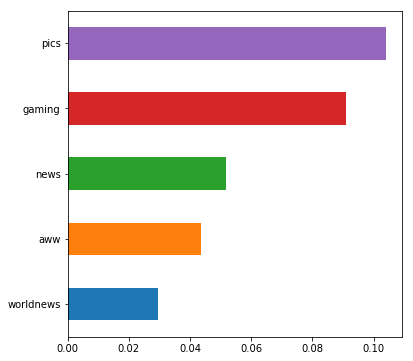

In [ ]:
rfscore_3(df_subred,'binary',5)

### Comments:

- The mean accuracy score improved substatially now.
- The main features continue to be `pics`, and `gaming`

### We can compute the `cross_val_score` corresponding to the best model from the cell above:

In [ ]:
def cv_score(df,target_col,cv,n_estimators,min_samples_split,max_depth):
    X = df.drop(target_col,axis=1)
    y = df[target_col]
    rf = RandomForestClassifier(n_estimators=n_estimators_best,min_samples_split=min_samples_split_best,
                                max_depth=max_depth_best)
    s = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
    return("{} Score is :{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

In [ ]:
dict_best = {'max_depth': 4, 'min_samples_split': 8, 'n_estimators': 180}
n_estimators_best = dict_best['n_estimators']
min_samples_split_best = dict_best['min_samples_split']
max_depth_best = dict_best['max_depth']
cv_score(df_subred,'binary',5,n_estimators_best,min_samples_split_best,max_depth_best)

'Random Forest Score is :0.588 ± 0.023'

## 7)  Model Building IV: Including thread features

I will now use CountVectorizer to create features based on the words in the thread titles. We will then combine this new table with the subreddits features table and build a new model.

### We first need to preprocess the text:

- We take out stopwords (common words, adding no meaning such as for example, "I", "am")
- Take out punctuation and spaces
- Converts text to lower case
- Use stemming (e.g. it converts the words scientific, scientist, science into scien).

The function below does that [1]. A few words regarding this function are in order:
- Using `PorterStemmer()` we groups words with same stems
- Using `stopwords.words('english')` we exclude stop words (in English) such as:

        ['i', 'me', 'my', 'myself', 'we',...]
    
- `maketrans()` creates a mapping table. We may create an empty mapping table, and then set the third argument of this function to all characters we want to remove during the translation process. For example:
        
        str.maketrans('', '', string.punctuation)
        str.maketrans('', '', string.digits)

- The function `translate()` maps a set of characters into another.
- Using `text.lower().strip()` we removes spaces

Some simple examples:

In [ ]:
import string
words_1 = 'One,TWO,1and 3'
w = [w.translate(str.maketrans(
    '','',string.digits)).translate(
    str.maketrans('','',
                  string.punctuation)).lower().strip() \
     for w in words_1]
w

['o', 'n', 'e', '', 't', 'w', 'o', '', '', 'a', 'n', 'd', '', '']

### The function we will use is given by:

In [ ]:
import string

def cleaner(text):
    stemmer = PorterStemmer()
    stop = stopwords.words('english')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = text.lower().strip()
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

Recalling `df`:

In [ ]:
df = pd.read_csv('df_with_binary_1.csv',index_col=0)
df.head()

,titles,times,subreddits,nums,binary
178,rainy afternoon,11,raining,10,0
180,Well this tweet took a wild turn,19,trashy,1242,1
181,Sweet ki..........nvm!,3,yesyesyesyesno,5,0
187,Two drunk gentlemen try to pass each other,17,StoppedWorking,102,1
192,Minute of silence,4,gwent,45,0


### Let us consider only words that occured min_df times or more:

In [ ]:
min_df = 1 # Set to 1 to get more data points
cvt = CountVectorizer(min_df=min_df, preprocessor=cleaner)
cvt.fit(df["titles"])
print('Words that showed up at least {} times:\n'.format(min_df))
print(cvt.get_feature_names(),'\n')
print('There are {} such words'.format(len(cvt.get_feature_names())))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function cleaner at 0x1a193ee1e0>, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Words that showed up at least 1 times:

['abandon', 'abgeb', 'abomin', 'absolut', 'absolutelynotmeirl', 'accept', 'accident', 'accord', 'account', 'accus', 'across', 'acryl', 'act', 'actual', 'ad', 'adapt', 'addit', 'administration', 'admit', 'adolf', 'adopt', 'aeiou', 'af', 'afghanistan', 'africa', 'afternoon', 'age', 'agenda', 'agent', 'aglet', 'ago', 'air', 'aja', 'alberta', 'album', 'alex', 'aliv', 'alleg', 'alon', 'alp', 'alreadi', 'alright', 'also', 'altright', 'alway', 'ama', 'amaz', 'amnesti', 'among', 'amount', 'ampat', 'android', 'anim', 'animaux', 'ankl', 'anon', 'anoth', 'antivenom', 'anyon', 'anyth', 'apart', 'app', 'appar', 'appear', 'appl', 'appreci', 'approach', 'april', 'aquaria', 'aquarium', 'archer', 'architectur', 'arena', 'arent', 'arithmet', 'arm', 'around', 'artwork', 'ashley', 'ask', 'ass', 'assassin', 'assault', 'assaultstyl', 'asylum', 'atheist', 'attack', 'attempt', 'aunt', 'austin', 'australia', 'australian', 'autobiographi', 'autour', 'av', 'avatar', 'aveng

Applying `cvt.transform` to a `Series` we obtain a sparse matrix:

In [ ]:
print('Matrix is:\n')
cvt.transform(df['titles']).todense()
print("")
print('The row {} is:\n'.format(30))
cvt.transform(df['titles']).todense()[30]

Matrix is:



matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])


The row 30 is:



matrix([[0, 0, 0, ..., 0, 0, 0]])

We can also use just `cvt.fit_transform` for the same result:

In [ ]:
cvt = CountVectorizer(min_df=min_df, preprocessor=cleaner)
print('Matrix is:\n')
cvt.fit_transform(df["titles"]).todense()
print("")
print('The row {} is:\n'.format(30))
cvt.fit_transform(df["titles"]).todense()[30]

Matrix is:



matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)


The row 30 is:



matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

We can plot histograms to find how many words are on each bin (the $x$-axis shows observed word frequencies above 3):

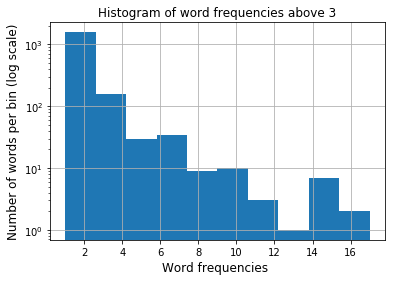

In [ ]:
pd.DataFrame(cvt.transform(df["titles"]).sum(axis=0),columns=cvt.get_feature_names()).T.hist()
plt.yscale('log')
plt.xlabel('Word frequencies ', fontsize=12);
plt.ylabel('Number of words per bin (log scale)', fontsize=12);
plt.title('Histogram of word frequencies above 3', fontsize=12);

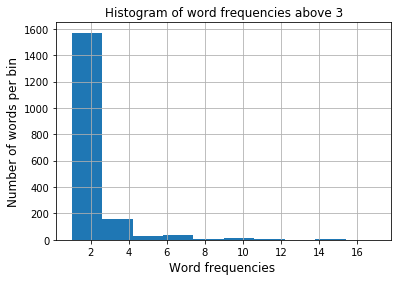

In [ ]:
pd.DataFrame(cvt.transform(df["titles"]).sum(axis=0),columns=cvt.get_feature_names()).T.hist()
plt.xlabel('Word frequencies ', fontsize=12);
plt.ylabel('Number of words per bin', fontsize=12);
plt.title('Histogram of word frequencies above 3', fontsize=12);

### Let us now build a `DataFrame`:

In [ ]:
min_df

1

In [ ]:
cvt = CountVectorizer(min_df=min_df, preprocessor=cleaner)
X_title = cvt.fit_transform(df["titles"])
X_thread = pd.DataFrame(X_title.todense(),
                        columns=cvt.get_feature_names())

X_thread.head()
X_thread.shape

,abandon,abgeb,abomin,absolut,absolutelynotmeirl,accept,accident,accord,account,accus,...,yosemit,you,young,your,yourself,ypg,zip,ክቿሠነ,ክቿዪሀዐሁነ,ጌዪቿልጕጎክኗ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(512, 1823)

### Let us examine the top 5 occuring words:

In [ ]:
print('The most common words are:\n')
X_thread.sum().sort_values(ascending=False).head()

The most common words are:



get     17
like    16
love    15
new     15
year    15
dtype: int64

### We will now join both datasets, the one about subreddits and the one about threads

In [ ]:
df_subred = pd.read_csv('subred_1.csv',index_col=0)
df_all = pd.concat([df_subred,X_thread],axis=1)
df_all.head()
df_all.shape

,binary,4PanelCringe,ACPocketCamp,AFL,ATBGE,AbandonedPorn,AccidentalWesAnderson,Android,AnimalsBeingBros,AnimalsBeingDerps,...,yosemit,you,young,your,yourself,ypg,zip,ክቿሠነ,ክቿዪሀዐሁነ,ጌዪቿልጕጎክኗ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(512, 2120)

In [ ]:
df_all.to_csv('df_threads_and_subreddits_new.csv')

Let us drop eventual duplicates:

In [ ]:
df_all.shape
df_all = df_all.T.drop_duplicates().T
df_all.shape

(512, 2120)

(512, 1080)

### We apply the last two functions steps again:
- Apply `rfscore2`
- Apply `rfscore_3`

Fitting 5 folds for each of 220 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:  3.1min finished


GridSearch results
The best parameters on the training data are:
 {'max_depth': 10, 'n_estimators': 30}
best max_depth: 10
best n_estimators: 30
best score is: 0.56
Is the prediction smaller (S) or larger (L) than the median:

['S', 'L', 'S', 'L', 'S', 'S', 'L', 'S', 'L', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'L', 'S', 'L', 'S', 'L', 'L', 'S', 'S', 'L', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'L', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'L', 'S']

W

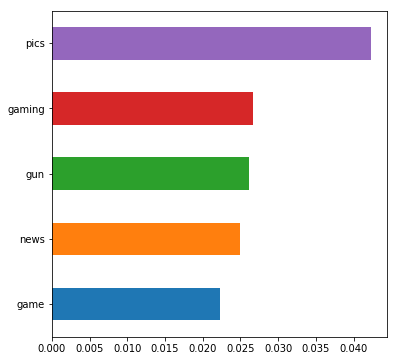

In [ ]:
n_estimators = list(range(20,220,10))
max_depth = list(range(2, 22, 2)) + [None]

rfscore2(df_all,'binary',0.3,n_estimators,max_depth)

Fitting 5 folds for each of 1100 candidates, totalling 5500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 5500 out of 5500 | elapsed: 17.3min finished


GridSearch results
The best parameters on the training data are:
 {'max_depth': 4, 'min_samples_split': 6, 'n_estimators': 30}
best max_depth: 4
best n_estimators: 30
best score is: 0.68
Is the prediction smaller (S) or larger (L) than the median:

['S', 'L', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'L', 'L', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', 'L', 'S', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 

Predicted Values    0    1
Actual Values             
0                 232   24
1                 142  114
Features and their importance:

AxesSubplot(0.125,0.125;0.775x0.755)


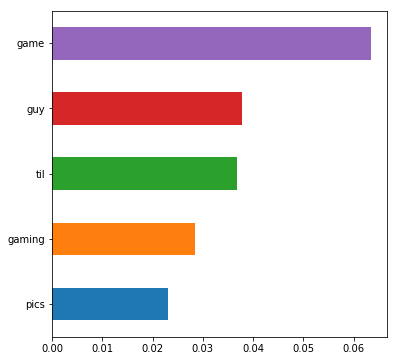

In [ ]:
rfscore_3(df_all,'binary',5)

## 8) Model Building V:  Predicting comments using a logistic regression:

In [ ]:
X = df_all.drop('binary', axis=1)
y = df_all['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.5324675324675324


In [ ]:
X = df_all.drop('binary', axis=1)
y = df_all['binary']
logregCV = LogisticRegressionCV()

In [ ]:
s_CV = cross_val_score(logregCV, X, y, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Logistic Regression CV", s_CV.mean().round(3), s_CV.std().round(3)))

Logistic Regression CV Score:	0.568 ± 0.029


# Executive Summary
---


### Conclusions:

1) The accuracy score is quite low, just slighly higher than the baseline when only the subreddits are considered.

2) With the parameters ranges in the `GridSearchCV` fixed, including words in the threads in addition to only subreddits dummies in the set of predictors increased the accuracy of the model compared with the case where only the latter was used, but only slighly.

3) The most significant gain came when we included a new hyperparameter, namely, `'min_samples_split` in the model and kept threads' words and subredddits as predictors. The accuracy in this case was close to 0.7.

4) The most common words in the threads are 'get','like' and 'love'.

5) The most important features in our best model were 'game', 'guy', both from the threads.

6) In a nutshell our best model was obtained considering both subredddits as dummies and words on the threads and keeping `max_depth`,`min_samples_split` and `n_estimators` as parameters to be scanned by the `GridSearchCV`

7) The obvious next step is to increase the number of scraped pages. Because our data was limited, we could not set a minimum frequency to the words. Taking only words that occur more frequently can help.

## References

[1] https://github.com/myarolin/Natural_Language_Processing_with_Reddit